# ***Imports***

In [1]:
# Data Handling & Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Utilities
from scipy.stats import randint
import shap
import joblib
import gradio as gr


# ***Data Handling***

In [3]:
# Step 1: Load the dataset
file_path = "data_500_cl_wm_rt_eq.csv"  # Update path if necessary
data = pd.read_csv(file_path)

# Show the first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
          cl         rt         wm         eq
0  394.54790  340.60360   1.521294  39.220715
1  386.34042  278.84058   1.981495  39.195120
2  437.21225  520.28296   1.433642  39.446140
3  346.49445  392.56418  17.386406  32.108770
4  378.06738  586.46510  20.535595  42.982193


In [4]:
# Step 2.1: Invert Reaction Time (so higher = better)
data['rt_inverted'] = 1 / (data['rt'] + 1e-6)
data.drop(columns=['rt'], inplace=True)
print(data.head())

          cl         wm         eq  rt_inverted
0  394.54790   1.521294  39.220715     0.002936
1  386.34042   1.981495  39.195120     0.003586
2  437.21225   1.433642  39.446140     0.001922
3  346.49445  17.386406  32.108770     0.002547
4  378.06738  20.535595  42.982193     0.001705


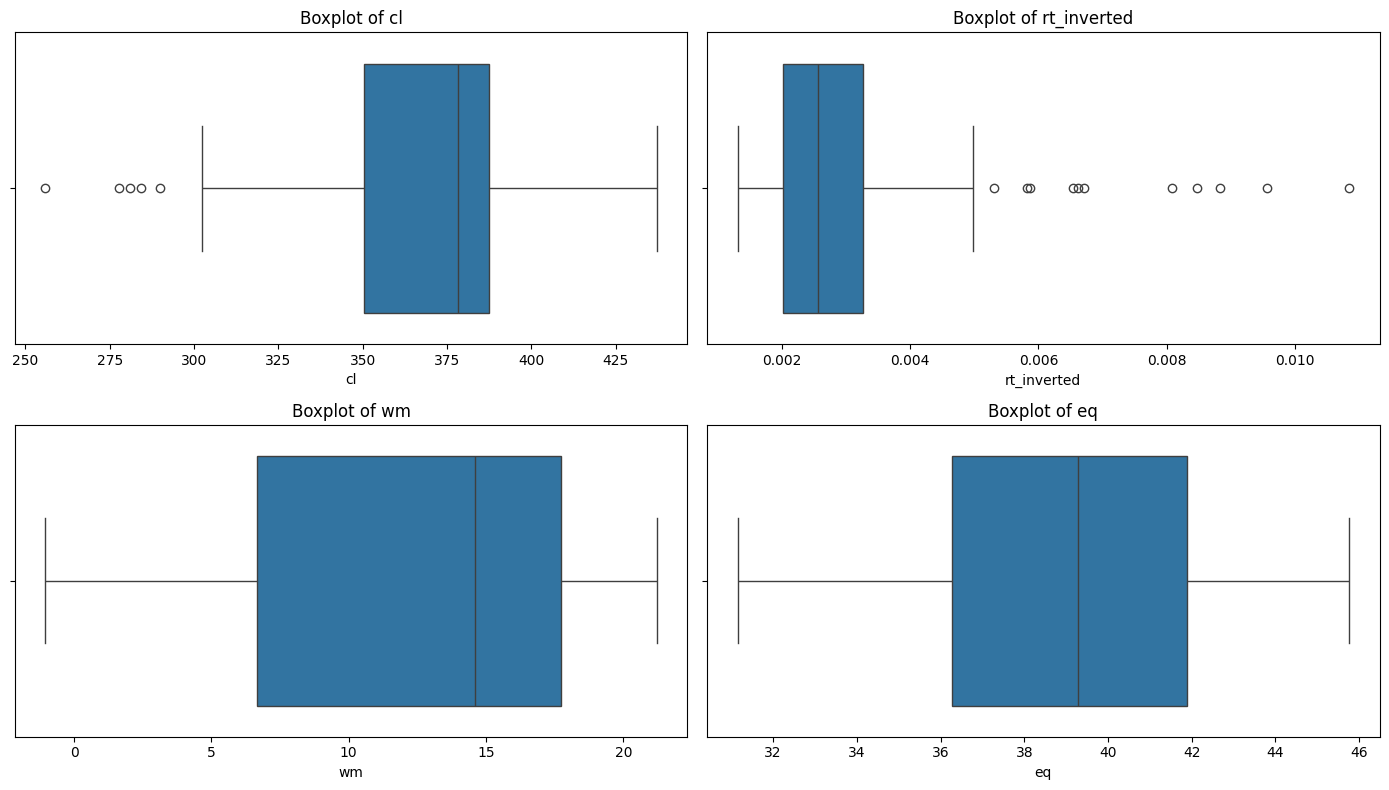

Outlier counts per feature:
{'cl': 5, 'rt_inverted': 11, 'wm': 0, 'eq': 0}


In [5]:
# Select only the relevant numeric columns
features = ['cl', 'rt_inverted', 'wm', 'eq']

# Plot boxplots and calculate outliers
outlier_counts = {}

plt.figure(figsize=(14, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data[col], orient="h")
    plt.title(f'Boxplot of {col}')

    # IQR method
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

plt.tight_layout()
plt.show()

print("Outlier counts per feature:")
print(outlier_counts)

In [6]:
#Remove outliers

# Calculate IQR for 'cl'
Q1 = data['cl'].quantile(0.25)
Q3 = data['cl'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print bounds (optional)
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Filter out the outliers
data = data[(data['cl'] >= lower_bound) & (data['cl'] <= upper_bound)]

# Calculate IQR for 'rt_inverted'
Q1 = data['rt_inverted'].quantile(0.25)
Q3 = data['rt_inverted'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print bounds (optional)
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Filter out the outliers
data = data[(data['rt_inverted'] >= lower_bound) & (data['rt_inverted'] <= upper_bound)]

# Confirm removal
print("Updated shape of data:", data.shape)

Lower Bound: 295.1078462499999, Upper Bound: 442.75935625000005
Lower Bound: 0.00015942502040955505, Upper Bound: 0.005100214074488766
Updated shape of data: (488, 4)


In [7]:
# Select features
X_base = data[['cl', 'wm', 'rt_inverted']]

# Generate polynomial and interaction features up to degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_base)

# Get feature names for reference
feature_names = poly.get_feature_names_out(['cl', 'wm', 'rt_inverted'])

# Create a DataFrame for better readability
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Check the new feature set
print("Polynomial Feature Names:")
print(feature_names)

# Optionally, concatenate with the original target
X_poly_df['eq'] = data['eq'].values

Polynomial Feature Names:
['cl' 'wm' 'rt_inverted' 'cl^2' 'cl wm' 'cl rt_inverted' 'wm^2'
 'wm rt_inverted' 'rt_inverted^2']


In [8]:
print(X_poly_df.head())

          cl         wm  rt_inverted           cl^2        cl wm  \
0  394.54790   1.521294     0.002936  155668.045394   600.223156   
1  386.34042   1.981495     0.003586  149258.920126   765.531495   
2  437.21225   1.433642     0.001922  191154.551550   626.806063   
3  346.49445  17.386406     0.002547  120058.403881  6024.293184   
4  378.06738  20.535595     0.001705  142934.943820  7763.838598   

   cl rt_inverted        wm^2  wm rt_inverted  rt_inverted^2         eq  
0        1.158379    2.314334        0.004466       0.000009  39.220715  
1        1.385524    3.926321        0.007106       0.000013  39.195120  
2        0.840336    2.055331        0.002756       0.000004  39.446140  
3        0.882644  302.287114        0.044289       0.000006  32.108770  
4        0.644655  421.710662        0.035016       0.000003  42.982193  


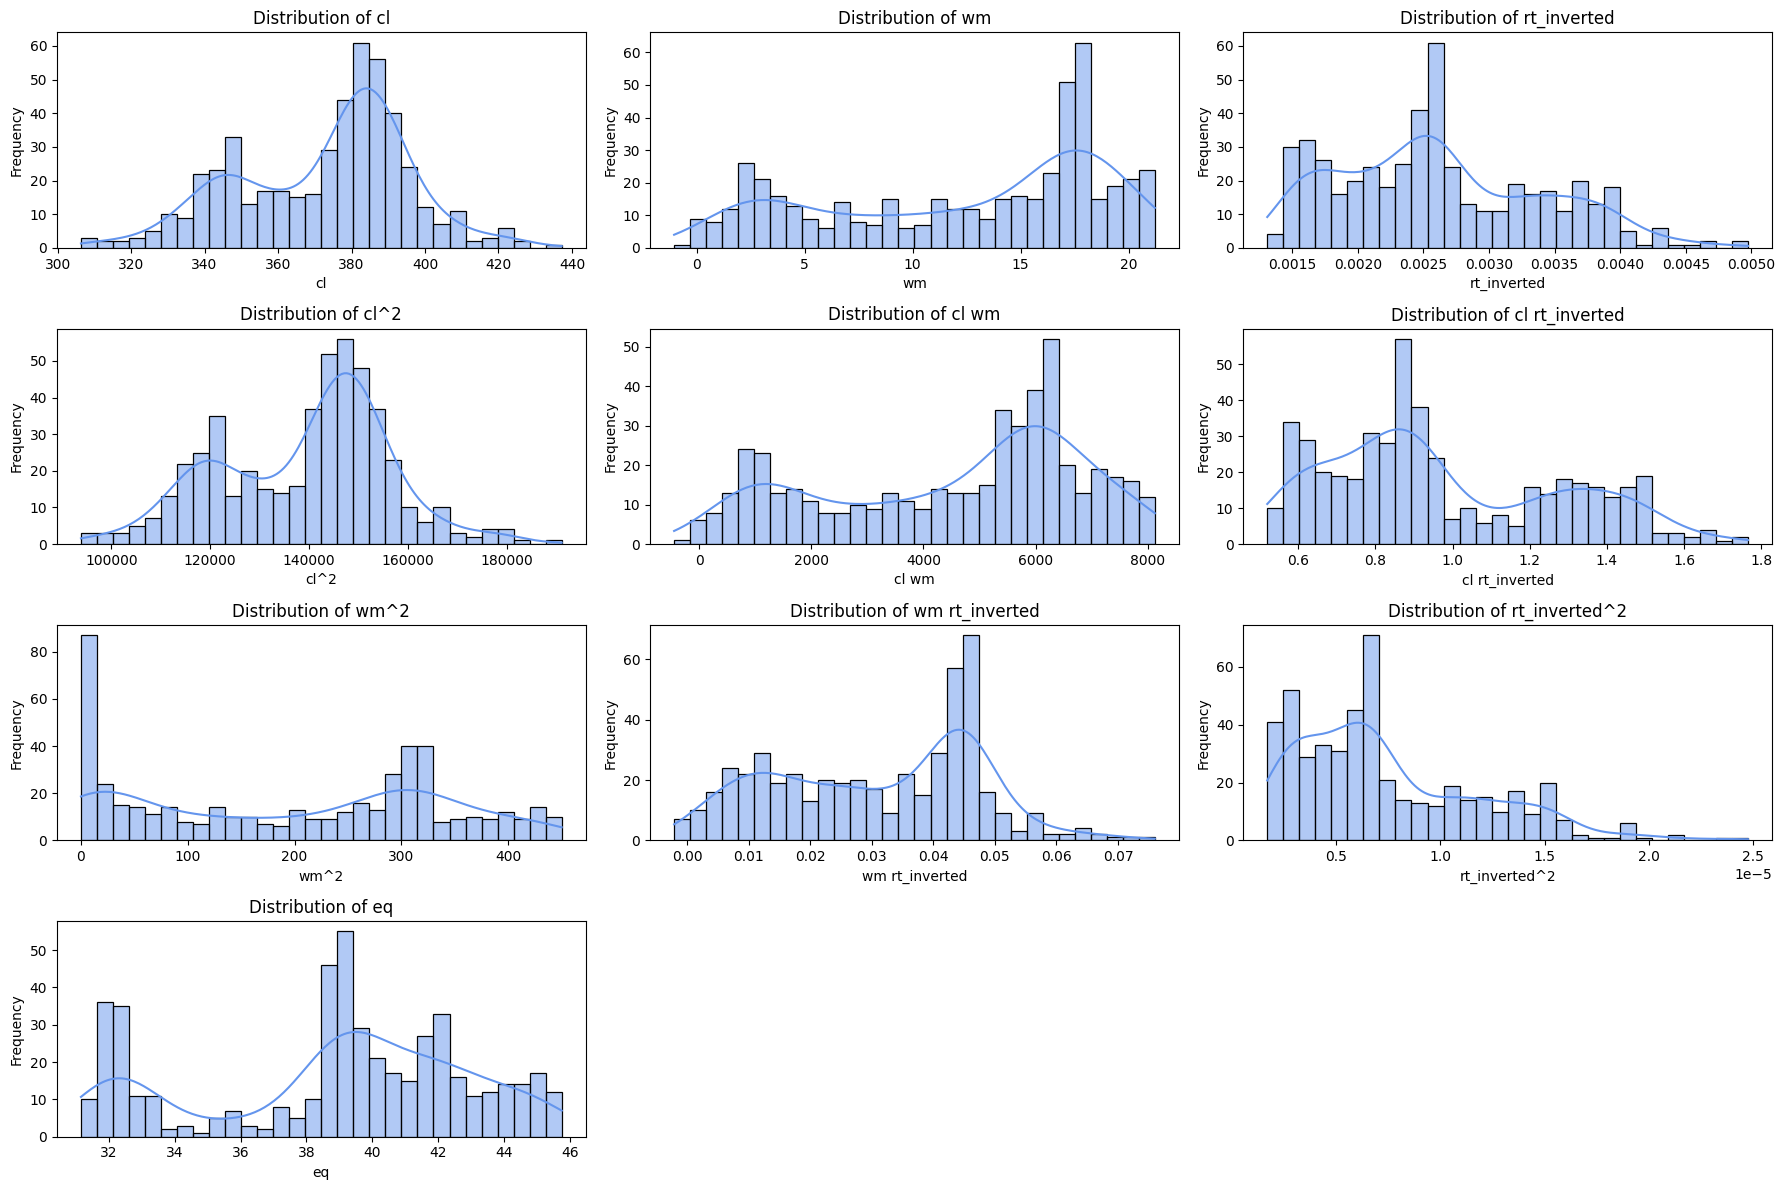

In [9]:
# Plot all 10 feature distributions
plt.figure(figsize=(18, 12))

for idx, feature in enumerate(X_poly_df.columns):
    plt.subplot(4, 3, idx + 1)
    sns.histplot(X_poly_df[feature], bins=30, kde=True, color='cornflowerblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
#Standerdization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly_df.drop(columns=['eq']))

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_poly_df.drop(columns=['eq']).columns)


In [11]:
# Preview scaled features
print("Scaled Features (first 5 rows):")
print(X_scaled_df.head())
Y=X_poly_df['eq']
print("\nTarget (first 5 rows):")
print(Y.head())

Scaled Features (first 5 rows):
         cl        wm  rt_inverted      cl^2     cl wm  cl rt_inverted  \
0  0.950037 -1.686728     0.409040  0.957684 -1.708525        0.609136   
1  0.596430 -1.615510     1.246333  0.582858 -1.636622        1.365733   
2  2.788168 -1.700292    -0.896419  3.033045 -1.696962       -0.450229   
3 -1.120276  0.768459    -0.091303 -1.124878  0.650749       -0.309304   
4  0.239998  1.255807    -1.175682  0.213013  1.407388       -1.102020   

       wm^2  wm rt_inverted  rt_inverted^2  
0 -1.350905       -1.583308       0.264490  
1 -1.339663       -1.423833       1.230493  
2 -1.352711       -1.686673      -0.857334  
3  0.740998        0.822524      -0.220816  
4  1.573815        0.262284      -1.036512  

Target (first 5 rows):
0    39.220715
1    39.195120
2    39.446140
3    32.108770
4    42.982193
Name: eq, dtype: float64


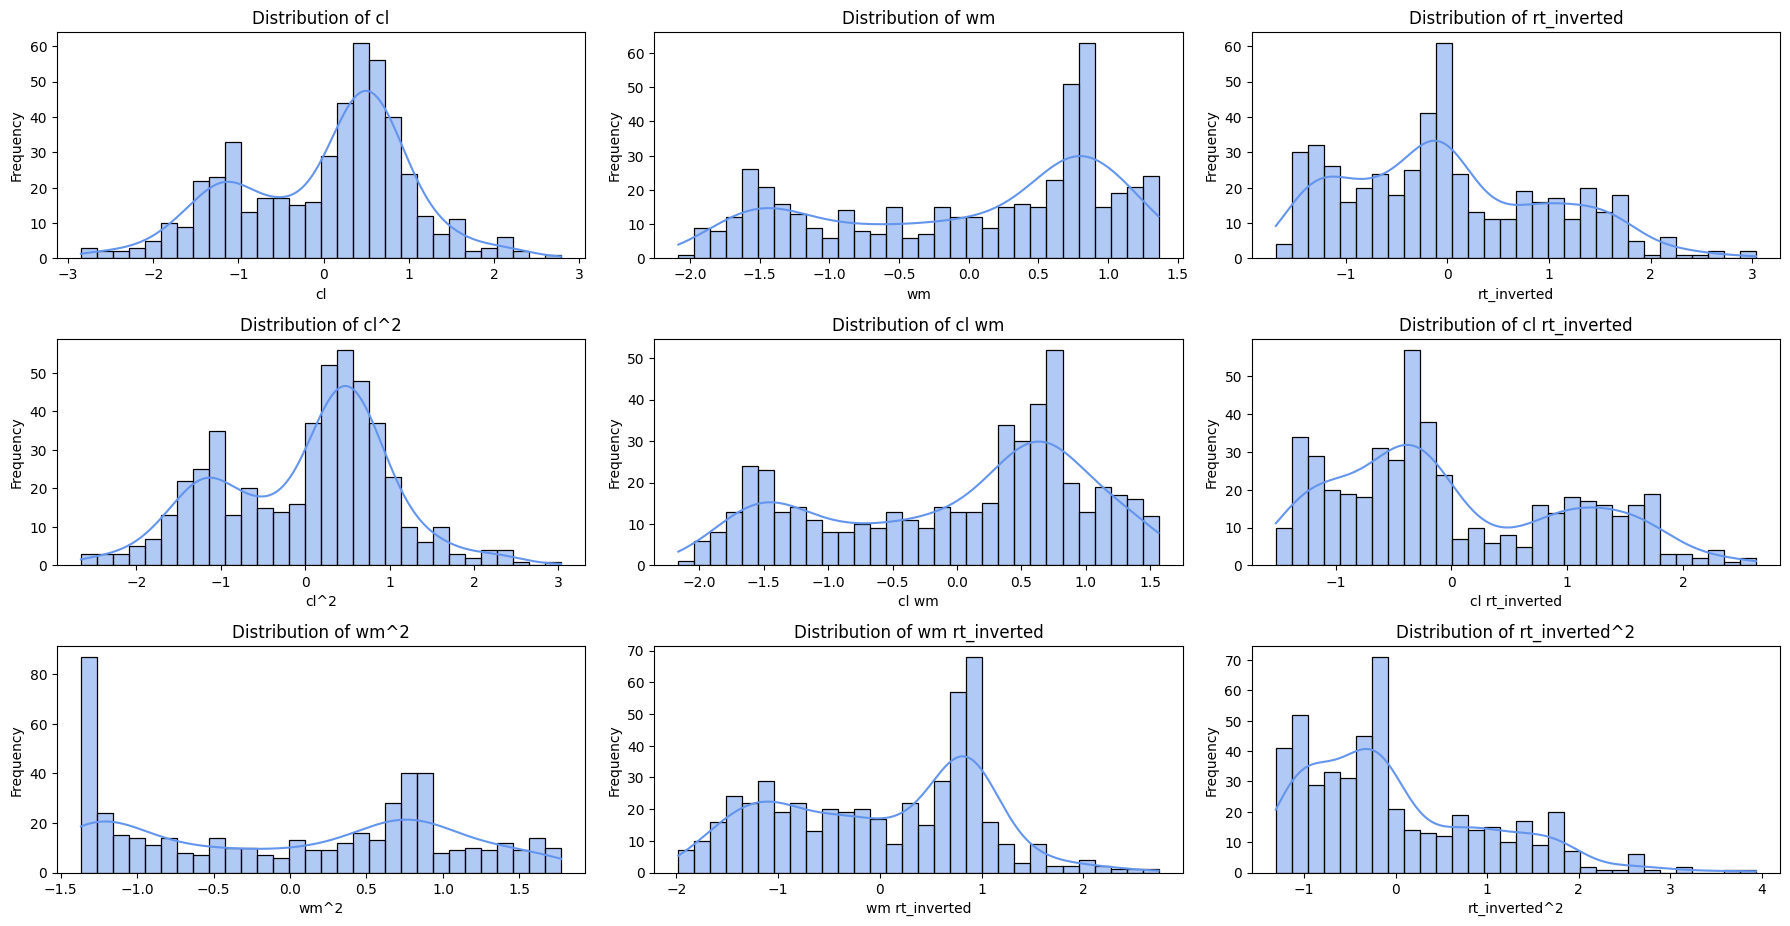

In [12]:
# Plot all 9 feature distributions
plt.figure(figsize=(18, 12))

for idx, feature in enumerate(X_scaled_df.columns):
    plt.subplot(4, 3, idx + 1)
    sns.histplot(X_scaled_df[feature], bins=30, kde=True, color='cornflowerblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

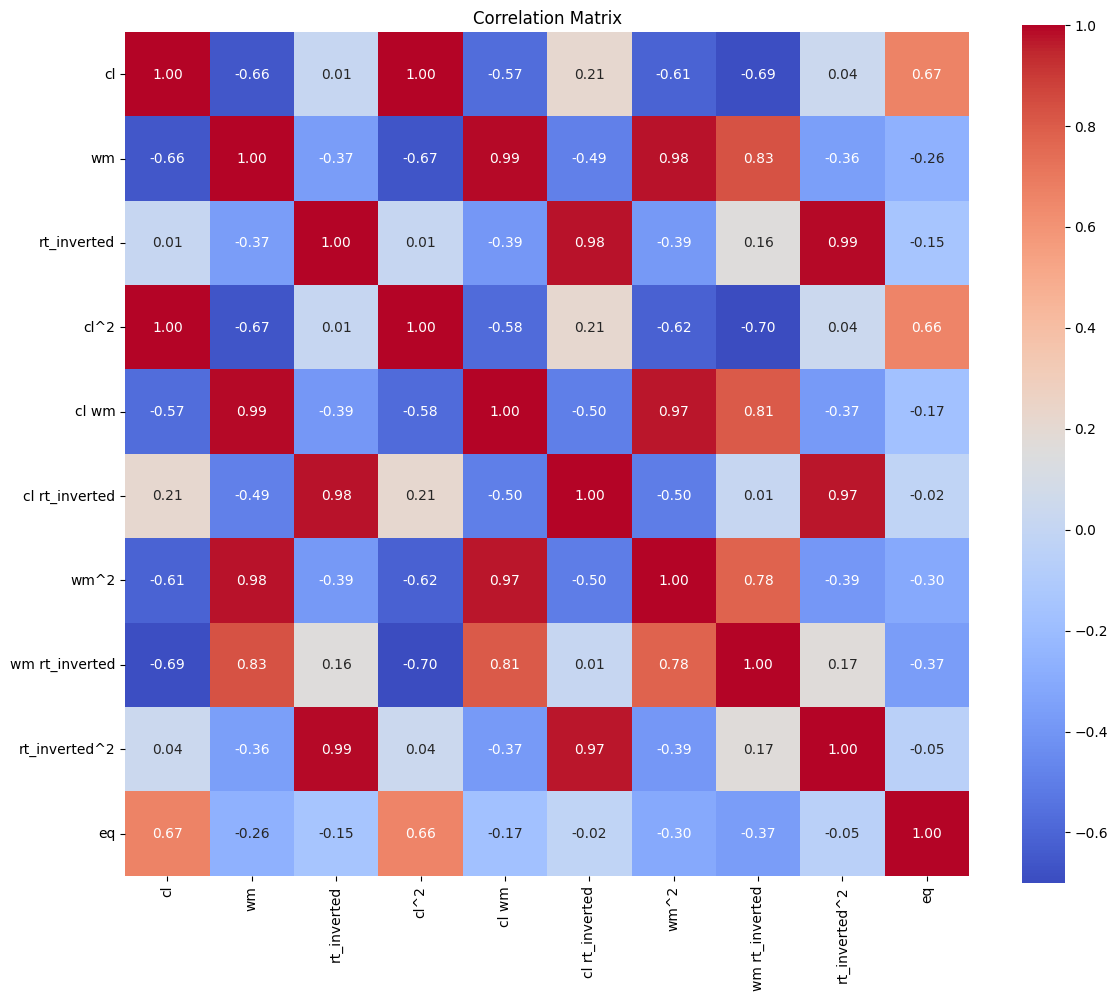

In [13]:
# Compute correlation matrix
corr = X_poly_df.corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [15]:
# X_poly_df already includes all engineered features
X = X_scaled_df  # Features
y = Y                # Target

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.30, random_state=42)

# Step 2: Then split temp into validation and test (15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


# ***RandomForestRegressor***

In [16]:
# Step 1: Define model
rf = RandomForestRegressor(random_state=42)

# Step 2: Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],         # number of trees
    'max_depth': [None, 5, 10, 15],          # depth of tree
    'min_samples_split': [2, 5, 10],         # min samples to split
    'min_samples_leaf': [1, 2, 4],           # min samples per leaf
    'max_features': ['sqrt', 'log2']         # number of features to consider at each split
}

# Step 3: Set up K-Fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Grid Search with CV
rf_grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # since we want to reduce MSE
                           cv=kfold,
                           n_jobs=-1,
                           verbose=2)

# Step 5: Fit to your training data
rf_grid_search.fit(X_train, y_train)

# Step 6: Get best model and evaluate
best_rf = rf_grid_search.best_estimator_
y_val_pred = best_rf.predict(X_val)

# Step 7: Metrics
r2_val = r2_score(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

print("✅ Best Parameters:", rf_grid_search.best_params_)
print(f"🎯 R² Score (Best RF): {r2_val}")
print(f"📉 MSE (Best RF): {mse_val}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✅ Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
🎯 R² Score (Best RF): 0.9521247077896133
📉 MSE (Best RF): 0.7851695291484326


In [19]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Extended search space
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30, 2)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 7),
    'max_features': ['sqrt', 'log2', None]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=200,  # Try 100 combinations
    scoring='neg_mean_squared_error',
    cv=kfold,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search_rf.fit(X_train, y_train)

print("✅ Best RF Params:", random_search_rf.best_params_)
y_pred_rf = random_search_rf.best_estimator_.predict(X_val)
print("🎯 R² (RF):", r2_score(y_val, y_pred_rf))
print("📉 MSE (RF):", mean_squared_error(y_val, y_pred_rf))


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
✅ Best RF Params: {'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 382}
🎯 R² (RF): 0.9534836858362826
📉 MSE (RF): 0.7628818708645437


# ***GradientBoostingRegressor***

In [21]:
# Step 1: Define the model
gbr = GradientBoostingRegressor(random_state=42)

# Step 2: Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Step 3: Define cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Grid search with cross-validation
gb_grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # because we want to minimize MSE
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Step 5: Fit on training data only
gb_grid_search.fit(X_train, y_train)

# Step 6: Evaluate on test set
best_gbr = gb_grid_search.best_estimator_
y_val_pred = best_gbr.predict(X_val)

# Step 7: Print metrics
r2 = r2_score(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)

print("✅ Best Parameters:", gb_grid_search.best_params_)
print(f"🎯 R² Score (Best GBR): {r2}")
print(f"📉 MSE (Best GBR): {mse}")


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
🎯 R² Score (Best GBR): 0.9458595785569252
📉 MSE (Best GBR): 0.8879195770868687


In [23]:
#Define the Model
gbr = GradientBoostingRegressor(random_state=42)

#Extended Search Space
param_dist_gbr = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30, 2)),
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 7)
}

#Randomized Search
random_search_gbr = RandomizedSearchCV(
    gbr,
    param_distributions=param_dist_gbr,
    n_iter=200,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search_gbr.fit(X_train, y_train)

print("✅ Best GBR Params:", random_search_gbr.best_params_)
y_pred_gbr = random_search_gbr.best_estimator_.predict(X_val)
print("🎯 R² (GBR):", r2_score(y_val, y_pred_gbr))
print("📉 MSE (GBR):", mean_squared_error(y_val, y_pred_gbr))


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
✅ Best GBR Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 304}
🎯 R² (GBR): 0.9442953371323906
📉 MSE (GBR): 0.9135736179516015


# ***XGBRegressor***

In [24]:
# Step 1: Define the model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Step 2: Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'max_depth': [None, 3, 5, 7, 10, 13, 15],
    'subsample': [0.3, 0.7, 1.0],
    'colsample_bytree': [0.3, 0.7, 1.0]
}
# Step 3: Define cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Grid search with cross-validation
xg_grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2
)

# Step 5: Fit on training data only
xg_grid_search.fit(X_train, y_train)

# Step 5: Fit on training data only
best_xgb = xg_grid_search.best_estimator_
y_val_pred = best_xgb.predict(X_val)

# Step 7: Print metrics
r2 = r2_score(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)

print("✅ Best Parameters:", xg_grid_search.best_params_)
print(f"🎯 R² Score (Best XGB): {r2}")
print(f"📉 MSE (Best XGB): {mse}")

Fitting 5 folds for each of 1323 candidates, totalling 6615 fits
✅ Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.3}
🎯 R² Score (Best XGB): 0.9506732414399904
📉 MSE (Best XGB): 0.8089740240703658


In [28]:
#define model
xgb = XGBRegressor(random_state=42)

#Extended Search Space
param_dist_xgb = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30, 2)),
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#Randomized Search
random_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=1500,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search_xgb.fit(X_train, y_train)

print("✅ Best XGB Params:", random_search_xgb.best_params_)
y_pred_xgb = random_search_xgb.best_estimator_.predict(X_val)
print("🎯 R² (XGB):", r2_score(y_val, y_pred_xgb))
print("📉 MSE (XGB):", mean_squared_error(y_val, y_pred_xgb))


Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
✅ Best XGB Params: {'colsample_bytree': 1.0, 'learning_rate': 0.15, 'max_depth': None, 'n_estimators': 116, 'subsample': 0.7}
🎯 R² (XGB): 0.9472524011034239
📉 MSE (XGB): 0.8650768585878165


# ***Feature Importance (Random Forest)***

<ipython-input-29-3262753221>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='Blues_d')


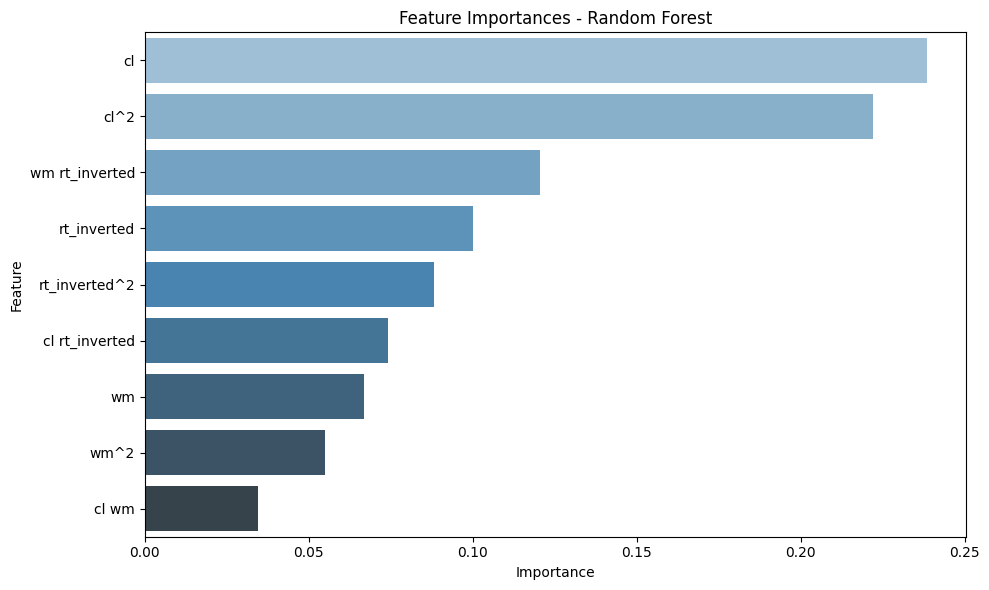

In [29]:
# Get the best model from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_

# Get feature importances
importances = best_rf.feature_importances_
feature_names = X_train.columns  # or use poly.get_feature_names_out([...]) if using PolynomialFeatures

# Create DataFrame for easier plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='Blues_d')
plt.title('Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


# ***SHAP and Explainer***

In [30]:
best_rf = random_search_rf.best_estimator_


In [31]:
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(best_rf)  # Replace `best_rf` with the best model


In [32]:
# Can use a subset of your data for faster results
shap_values = explainer.shap_values(X_val)


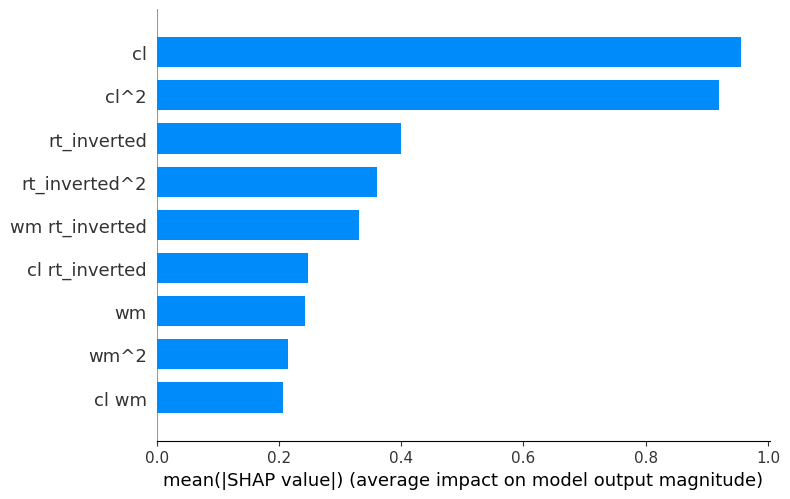

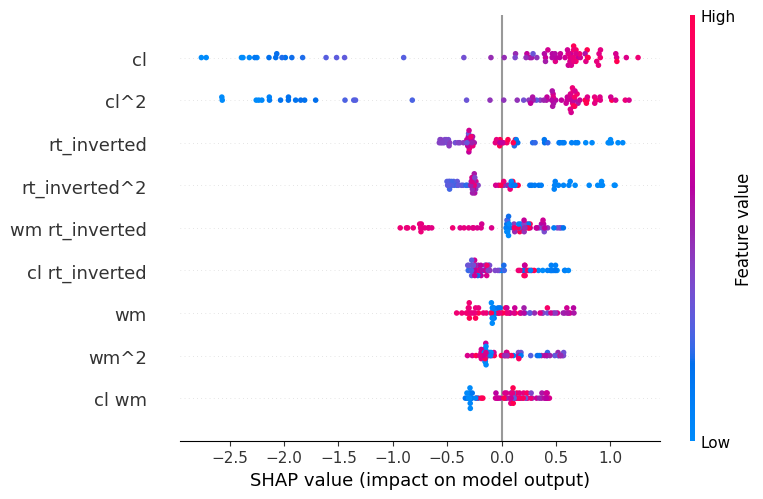

In [33]:
shap.summary_plot(shap_values, X_val, plot_type="bar")  # Bar plot of average importance
shap.summary_plot(shap_values, X_val)  # Beeswarm plot for distribution of impacts


# ***Testing***

In [35]:
# Predict on test set using the best model (e.g., best_rf from RandomizedSearchCV)
y_test_pred = best_rf = random_search_rf.best_estimator_.predict(X_test)

# Metrics
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("🎯 R² Score on Test Set:", test_r2)
print("📉 MSE on Test Set:", test_mse)

🎯 R² Score on Test Set: 0.9662222804314797
📉 MSE on Test Set: 0.6139436157927488


# ***PLOTS***

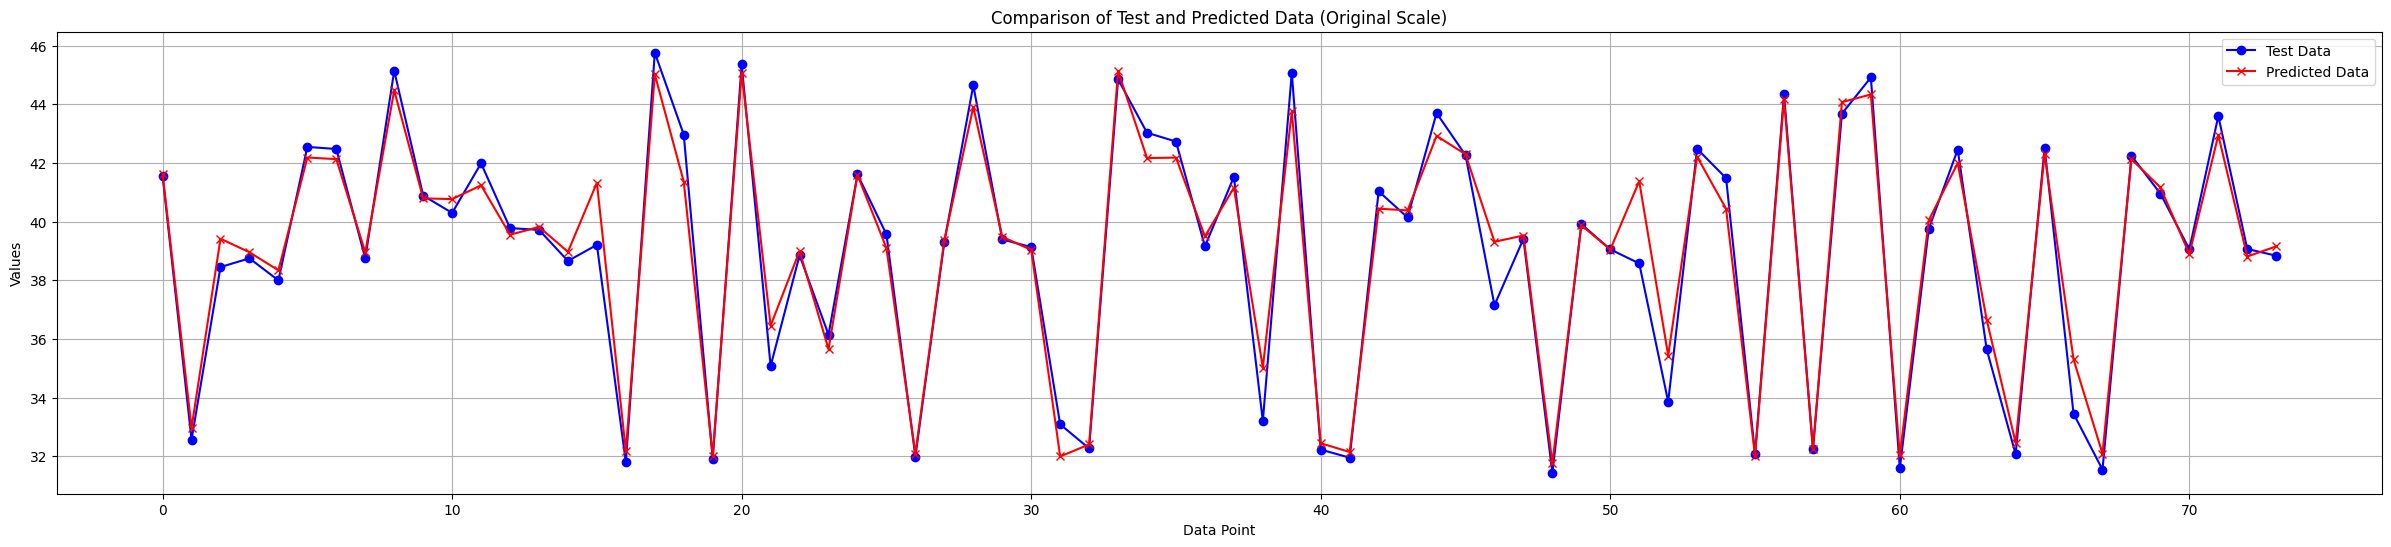

In [36]:
# Line Plot
plt.figure(figsize=(30, 6))
plt.plot(range(len(y_test)), y_test, marker='o', color='blue', label='Test Data')
plt.plot(range(len(y_test_pred)), y_test_pred, marker='x', color='red', label='Predicted Data')
plt.xlabel('Data Point')
plt.ylabel('Values')
plt.title('Comparison of Test and Predicted Data (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

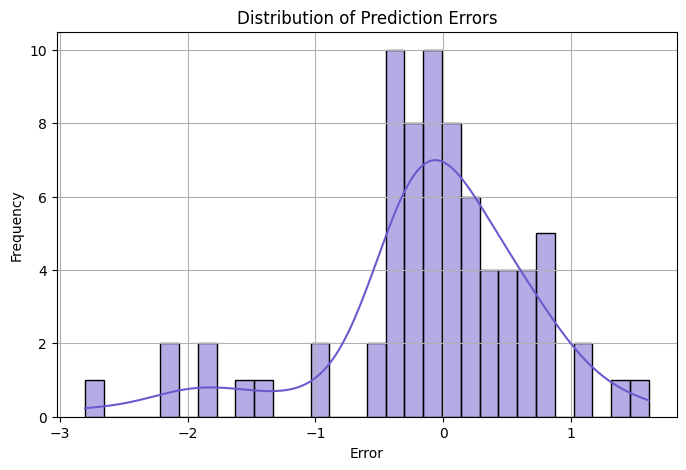

In [37]:
#Distribution of Prediction Errors
errors = y_test - y_test_pred
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True, color='slateblue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# ***DEMO***

In [38]:
# Save the model and preprocessing steps
best_rf = rf_grid_search.best_estimator_
joblib.dump(best_rf, "best_rf_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(poly, "poly.joblib")

['poly.joblib']

In [39]:
# Load the saved components
model = joblib.load("best_rf_model.joblib")
scaler = joblib.load("scaler.joblib")
poly = joblib.load("poly.joblib")  # this is your PolynomialFeatures

# Define the prediction function
def predict_eq(cl, wm, rt):
    # Invert RT as done in preprocessing
    rt_inverted = 1 / (rt + 1e-6)

    # Create input array
    input_features = np.array([[cl, wm, rt_inverted]])

    # Polynomial transformation
    input_poly = poly.transform(input_features)

    # Standardize
    input_scaled = scaler.transform(input_poly)

    # Predict
    prediction = model.predict(input_scaled)[0]
    return round(prediction, 3)

# Set up Gradio interface
interface = gr.Interface(
    fn=predict_eq,
    inputs=[
        gr.Number(label="Cognitive Load (cl)"),
        gr.Number(label="Working Memory (wm)"),
        gr.Number(label="Reaction Time (rt)"),
    ],
    outputs=gr.Number(label="Predicted Emotional Intelligence (eq)"),
    title="EI Predictor",
    description="Predict Emotional Intelligence based on Cognitive Load, Working Memory, and Reaction Time"
)

# Launch the app
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://85c20b2f08cc4415a5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
